CS 282 (Computer Vision) <br>
Programming Assignment 2 <br>
Image Stitching <br>

Professor: Dr. Prospero C. Naval Jr. <br>
Student: Deomary Angelo B. Franco, 202322049 <br>

In [2]:
import cv2
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import platform

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s'
)

logging.info("OpenCV version: %s", cv2.__version__)
logging.info("Operating System: %s", platform.platform())

2026-03-01 21:55:05,476 - OpenCV version: 4.11.0
2026-03-01 21:55:05,477 - Operating System: macOS-26.3-arm64-arm-64bit


# PARAMETERS

In [ ]:
# -- PARAMETERS ----------------------------------------------------------------
# Parameters for Harris detection:
#   blockSize = 3 : Size of the neighborhood used to compute the covariance matrix.
#                   Larger values smooth the response, reducing noise but also precision.
#   ksize = 3 : Aperture of the Sobel gradient operator (must be odd: 1,3,5,7).
#   k = 0.04 : Harris sensitivity constant. Range [0.04, 0.06] is standard.
#              Larger k suppresses corners detected in edge-like regions.
HARRIS_BLOCK_SIZE = 3
HARRIS_KSIZE = 3
HARRIS_K = .05
HARRIS_THRESH_REL = 0.01  # keep pixels whose response > 1% of the max response

NMS_KERNEL_SIZE = 9

# PATCH_SIZE controls the descriptor field-of-view:
#   Smaller (11, 21): faster, less distinctive, better for fine textures
#   Larger (31, 41):  more distinctive for complex structures, but more sensitive
#                     to viewpoint change and requires more border padding
# We use 31x31 as the primary choice after experimentation.
PATCH_SIZE = 31          # tried also 21 and 41
HALF = PATCH_SIZE // 2   # 15 for patch_size=31

TOP_N = 500   # number of putative match pairs to retain

RANSAC_ITERATIONS = 1000   # guarantees >99.9% success even with 50% outlier rate
RANSAC_THRESHOLD  = 5.0    # inlier threshold in pixels

# Step 1: Load Images and Convert to Double (float64) and Grayscale

2026-03-01 21:55:05,486 - Left  image shape: (683, 1024, 3)  dtype: uint8
2026-03-01 21:55:05,487 - Right image shape: (683, 1024, 3)  dtype: uint8
2026-03-01 21:55:05,493 - Grayscale float64 range - Left:  [0.0078, 1.0000]
2026-03-01 21:55:05,493 - Grayscale float64 range - Right: [0.0118, 0.9922]


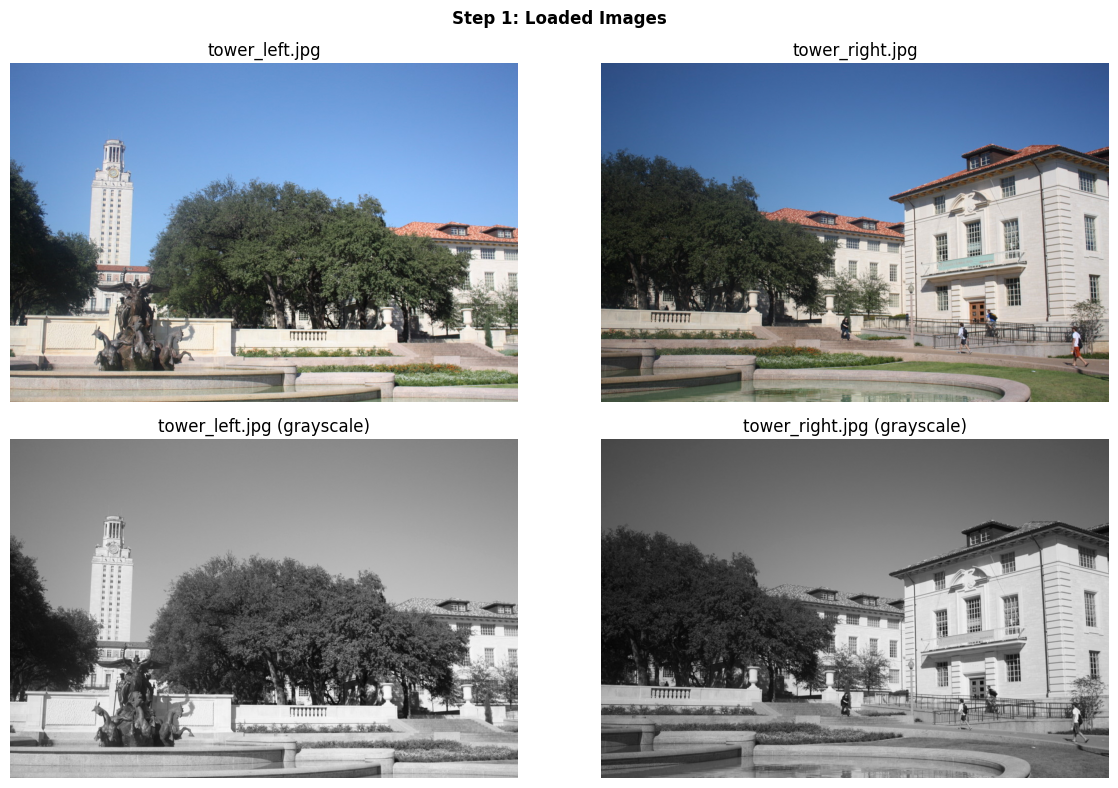

In [3]:
# ── Step 1: Load images, convert to float64 and grayscale ──────────────────
# Load the image pair using OpenCV (reads as BGR uint8 by default)
IMG_DIR = 'PA2-Image_Stitching/imgpairs'
img_left_bgr  = cv2.imread(os.path.join(IMG_DIR, 'tower_left.jpg'))
img_right_bgr = cv2.imread(os.path.join(IMG_DIR, 'tower_right.jpg'))

assert img_left_bgr  is not None, "tower_left.jpg not found"
assert img_right_bgr is not None, "tower_right.jpg not found"

logging.info("Left  image shape: %s  dtype: %s", img_left_bgr.shape,  img_left_bgr.dtype)
logging.info("Right image shape: %s  dtype: %s", img_right_bgr.shape, img_right_bgr.dtype)

# Convert BGR uint8 -> RGB float64 in [0, 1] for display and processing.
img_left_rgb  = cv2.cvtColor(img_left_bgr,  cv2.COLOR_BGR2RGB).astype(np.float64) / 255.0
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB).astype(np.float64) / 255.0

# Convert to grayscale float64 in [0, 1] for Harris detection and descriptor extraction.
# cv2.COLOR_BGR2GRAY applies the standard luminance formula: 0.114*B + 0.587*G + 0.299*R
img_left_gray  = cv2.cvtColor(img_left_bgr,  cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0
img_right_gray = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2GRAY).astype(np.float64) / 255.0

logging.info("Grayscale float64 range - Left:  [%.4f, %.4f]", img_left_gray.min(),  img_left_gray.max())
logging.info("Grayscale float64 range - Right: [%.4f, %.4f]", img_right_gray.min(), img_right_gray.max())

# Display both images side-by-side
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].imshow(img_left_rgb);  axes[0,0].set_title('tower_left.jpg');  axes[0,0].axis('off')
axes[0,1].imshow(img_right_rgb); axes[0,1].set_title('tower_right.jpg'); axes[0,1].axis('off')
axes[1,0].imshow(img_left_gray, cmap='gray');  axes[1,0].set_title('tower_left.jpg (grayscale)');  axes[1,0].axis('off')
axes[1,1].imshow(img_right_gray, cmap='gray'); axes[1,1].set_title('tower_right.jpg (grayscale)'); axes[1,1].axis('off')
plt.suptitle('Step 1: Loaded Images', fontweight='bold')
plt.tight_layout(); plt.show()

# Step 2: Harris Corner Detection

The Harris detector identifies corners by analyzing the eigenvalues of the second-moment
matrix (structure tensor) of local image gradients. A corner is a point where the
second-moment matrix has two large eigenvalues — meaning intensity changes significantly
in all directions. The Harris response score `R = det(M) - k * trace(M)^2` scores each pixel.

2026-03-01 21:55:05,768 - Harris keypoints detected (after NMS): Left=1062  Right=1151


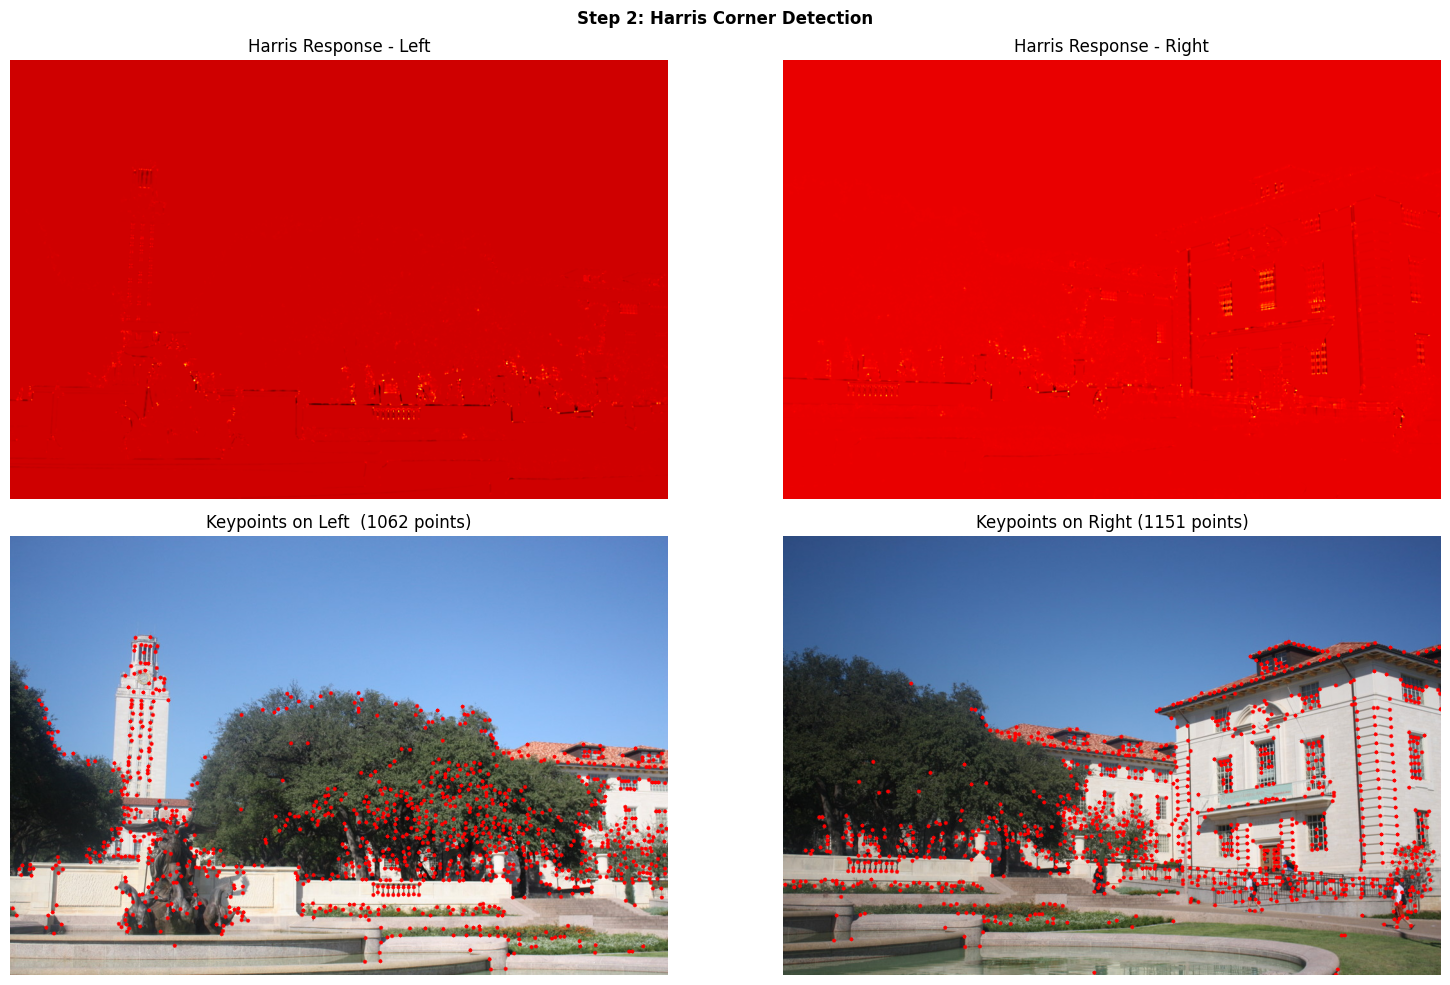

In [5]:
# -- Step 2: Harris Corner Detection -------------------------------------------

# cornerHarris requires float32 input
harris_left = cv2.cornerHarris(
    img_left_gray.astype(np.float32),
    blockSize=HARRIS_BLOCK_SIZE,
    ksize=HARRIS_KSIZE,
    k=HARRIS_K
)
harris_right = cv2.cornerHarris(
    img_right_gray.astype(np.float32),
    blockSize=HARRIS_BLOCK_SIZE,
    ksize=HARRIS_KSIZE,
    k=HARRIS_K
)

# Apply Non-Maximum Suppression (NMS) via morphological dilation.
# A pixel is a local maximum only if its value equals the maximum in its 9x9 neighborhood.
# This prevents clusters of nearby responses from all being accepted as keypoints.
nms_kernel = np.ones(
    (NMS_KERNEL_SIZE, NMS_KERNEL_SIZE), 
    np.uint8
)
harris_left_dil  = cv2.dilate(harris_left,  nms_kernel)
harris_right_dil = cv2.dilate(harris_right, nms_kernel)

# Threshold: keep only the top 1% of response values AND local maxima
thresh_left  = HARRIS_THRESH_REL * harris_left.max()
thresh_right = HARRIS_THRESH_REL * harris_right.max()

# kp_left/kp_right: arrays of (row, col) keypoint locations
kp_left  = np.argwhere(
    (harris_left  == harris_left_dil)  & (harris_left  > thresh_left)
)
kp_right = np.argwhere(
    (harris_right == harris_right_dil) & (harris_right > thresh_right)
)

logging.info("Harris keypoints detected (after NMS): Left=%d  Right=%d",
             len(kp_left), len(kp_right))

# Visualize Harris response map and detected keypoints
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes[0,0].imshow(harris_left,  cmap='hot')
axes[0,0].set_title('Harris Response - Left')
axes[0,0].axis('off')
axes[0,1].imshow(harris_right, cmap='hot')
axes[0,1].set_title('Harris Response - Right')
axes[0,1].axis('off')

# Overlay keypoints on color images (convert to uint8 for cv2.circle)
img_left_kp  = (img_left_rgb * 255).astype(np.uint8).copy()
img_right_kp = (img_right_rgb * 255).astype(np.uint8).copy()
for y, x in kp_left:
    cv2.circle(
        img=img_left_kp, 
        center=(x, y), 
        radius=3, 
        color=(255, 0, 0), 
        thickness=-1
    )
for y, x in kp_right:
    cv2.circle(
        img=img_right_kp, 
        center=(x, y), 
        radius=3, 
        color=(255, 0, 0), 
        thickness=-1
    )

axes[1,0].imshow(img_left_kp)
axes[1,0].set_title(f'Keypoints on Left  ({len(kp_left)} points)')
axes[1,0].axis('off')
axes[1,1].imshow(img_right_kp)
axes[1,1].set_title(f'Keypoints on Right ({len(kp_right)} points)')
axes[1,1].axis('off')

plt.suptitle('Step 2: Harris Corner Detection', fontweight='bold')
plt.tight_layout()
plt.show();

# Step 3: Extract Patch Descriptors

For each keypoint, extract a fixed-size square patch from the grayscale image centered
at that keypoint. Flatten the patch to a 1D vector — this is the descriptor.
Keypoints too close to the image border (within half the patch size) are discarded
to avoid out-of-bounds access. We experiment with patch sizes 21x21, 31x31, and 41x41.

2026-03-01 21:55:05,982 - Patch size: 31x31  ->  descriptor dim: 961
2026-03-01 21:55:05,983 - Valid keypoints after border filtering: Left=1041  Right=1139
2026-03-01 21:55:05,983 - Descriptor matrices: Left=(1041, 961)  Right=(1139, 961)


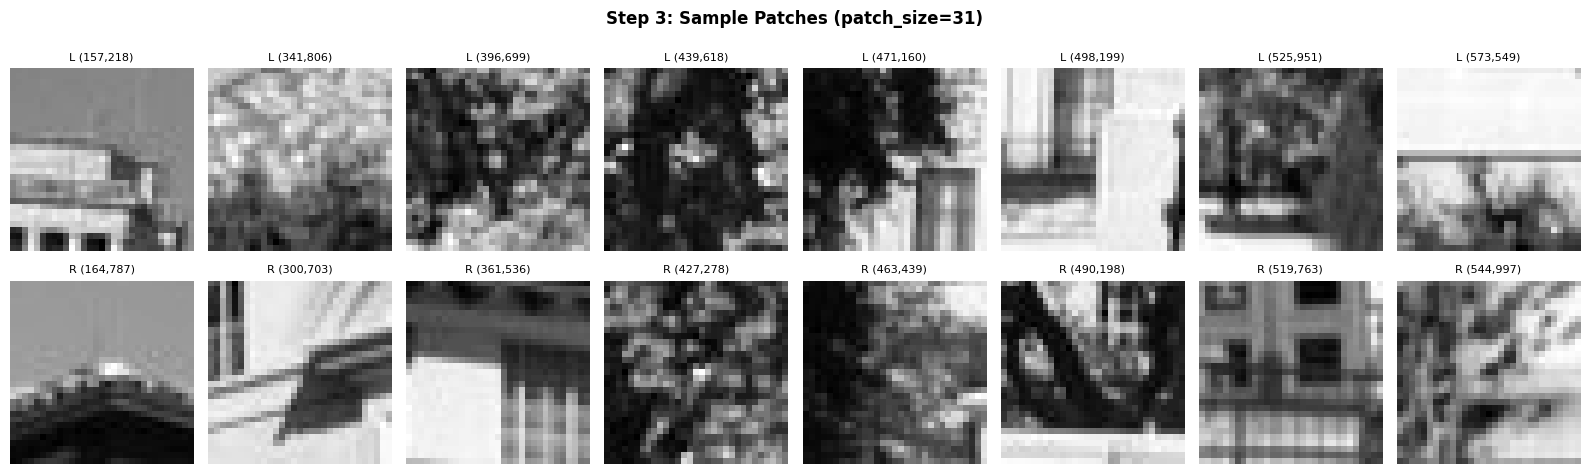

In [6]:
# -- Step 3: Extract Patch Descriptors -----------------------------------------

H_img, W_img = img_left_gray.shape   # 683, 1024

def extract_descriptors(gray_img: np.ndarray, 
                        keypoints: np.ndarray, 
                        half: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract flattened patch descriptors for each keypoint.
    
    Arg:
        gray_img  : float64 grayscale image, shape (H, W)
        keypoints : array of (row, col) pairs, shape (N, 2)
        half      : half-width of the patch (patch is (2*half+1) x (2*half+1))
    
    Return:
        valid_kp   : filtered keypoints (border-safe), shape (M, 2)
        descriptors: float64 descriptor matrix, shape (M, patch_size^2)
    """
    H, W = gray_img.shape
    valid_kp = []
    descriptors = []
    
    for y, x in keypoints:
        # Discard keypoints whose patch would extend beyond the image boundary
        if y - half < 0 or y + half >= H or x - half < 0 or x + half >= W:
            continue
        # Extract (2*half+1) x (2*half+1) patch centered at (r, c)
        patch = gray_img[y - half : y + half + 1,
                         x - half : x + half + 1]   # shape: (patch_size, patch_size)
        # Flatten to 1D descriptor vector; normalize to zero-mean for brightness invariance
        desc = patch.ravel().astype(np.float64)      # shape: (patch_size^2,)
        desc = desc - desc.mean()                    # zero-mean normalization
        valid_kp.append((y, x))
        descriptors.append(desc)
    
    return np.array(valid_kp), np.array(descriptors)

# Extract descriptors for both images
kp_left_valid,  desc_left  = extract_descriptors(img_left_gray,  kp_left,  HALF)
kp_right_valid, desc_right = extract_descriptors(img_right_gray, kp_right, HALF)

logging.info("Patch size: %dx%d  ->  descriptor dim: %d",
             PATCH_SIZE, PATCH_SIZE, PATCH_SIZE**2)
logging.info("Valid keypoints after border filtering: Left=%d  Right=%d",
             len(kp_left_valid), len(kp_right_valid))
logging.info("Descriptor matrices: Left=%s  Right=%s",
             desc_left.shape, desc_right.shape)

# Display a sample of extracted patches for visual inspection
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
step = max(1, len(kp_left_valid) // 8)
for i in range(8):
    y, x = kp_left_valid[i * step]
    patch = img_left_gray[y-HALF:y+HALF+1, x-HALF:x+HALF+1]
    axes[0, i].imshow(patch, cmap='gray'); axes[0, i].axis('off')
    axes[0, i].set_title(f'L ({y},{x})', fontsize=8)

step_r = max(1, len(kp_right_valid) // 8)
for i in range(8):
    y, x = kp_right_valid[i * step_r]
    patch = img_right_gray[y-HALF:y+HALF+1, x-HALF:x+HALF+1]
    axes[1, i].imshow(patch, cmap='gray'); axes[1, i].axis('off')
    axes[1, i].set_title(f'R ({y},{x})', fontsize=8)

axes[0, 0].set_ylabel('Left', fontsize=10)
axes[1, 0].set_ylabel('Right', fontsize=10)
plt.suptitle(f'Step 3: Sample Patches (patch_size={PATCH_SIZE})', fontweight='bold')
plt.tight_layout(); plt.show()

# Step 4: Compute Pairwise Euclidean Distances Between Descriptors

We compute the full N_left x N_right distance matrix where entry `D[i,j]` is the
Euclidean distance between descriptor i from the left image and descriptor j from
the right image. This is done with vectorized numpy for efficiency.

The formula used is: `||a - b||^2 = ||a||^2 + ||b||^2 - 2*(a . b)`

2026-03-01 21:55:06,153 - Distance matrix shape: (1041, 1139)  (N_left=1041, N_right=1139)


2026-03-01 21:55:06,154 - Distance matrix stats: min=0.7105  max=19.4814  mean=7.8929


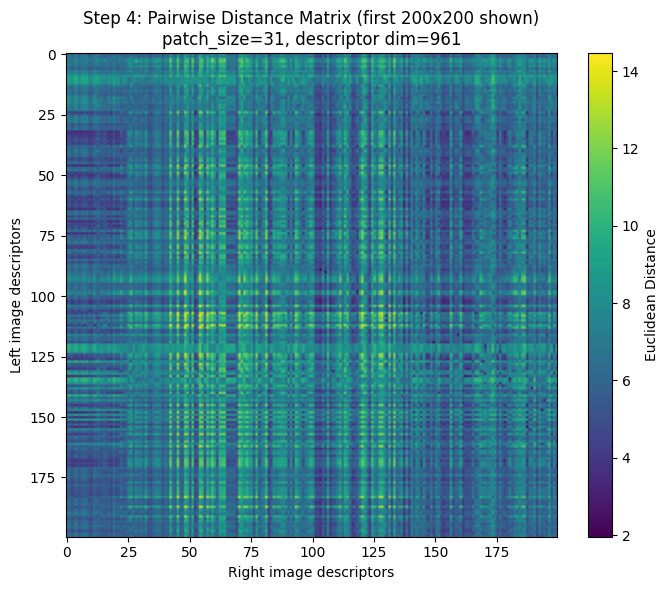

In [7]:
# -- Step 4: Compute Pairwise Euclidean Distance Matrix ------------------------
# We use the algebraic identity to avoid explicit broadcasting of the difference:
#   ||desc_left[i] - desc_right[j]||^2 = ||desc_left[i]||^2 + ||desc_right[j]||^2 - 2 * (desc_left[i] . desc_right[j])
#
# This formulation:
#   - Avoids allocating a (N_left, N_right, dim) tensor (which would be ~GB for large N)
#   - Is O(N_left * N_right * dim) but with BLAS-optimized matrix multiplication

# Squared L2 norms for each descriptor: shapes (N_left, 1) and (N_right, 1)
norm_left_sq  = np.sum(desc_left  ** 2, axis=1, keepdims=True)   # (N_left, 1)
norm_right_sq = np.sum(desc_right ** 2, axis=1, keepdims=True)   # (N_right, 1)

# Cross-product term: (N_left, N_right)
cross_term = desc_left @ desc_right.T

# Squared distance matrix: (N_left, N_right)
# np.maximum guards against small negative values due to floating-point rounding
dist_sq = norm_left_sq + norm_right_sq.T - 2.0 * cross_term
dist_sq = np.maximum(dist_sq, 0.0)

# Euclidean distance matrix: (N_left, N_right)
dist_matrix = np.sqrt(dist_sq)

logging.info("Distance matrix shape: %s  (N_left=%d, N_right=%d)",
             dist_matrix.shape, len(kp_left_valid), len(kp_right_valid))
logging.info("Distance matrix stats: min=%.4f  max=%.4f  mean=%.4f",
             dist_matrix.min(), dist_matrix.max(), dist_matrix.mean())

# Visualize the distance matrix as a heatmap (subsampled for display)
plt.figure(figsize=(7, 6))
plt.imshow(dist_matrix[:200, :200], cmap='viridis', aspect='auto')
plt.colorbar(label='Euclidean Distance')
plt.title(f'Step 4: Pairwise Distance Matrix (first 200x200 shown)\n'
          f'patch_size={PATCH_SIZE}, descriptor dim={PATCH_SIZE**2}')
plt.xlabel('Right image descriptors'); plt.ylabel('Left image descriptors')
plt.tight_layout(); plt.show()

# Step 5: Select Putative Matches

We select the top-500 descriptor pairs with the smallest Euclidean distances as
putative (candidate) matches. Using a fixed count (rather than a threshold) gives
predictable RANSAC input regardless of descriptor scale.

In [27]:
# -- Step 5: Select Putative Matches -------------------------------------------
# Strategy: flatten the distance matrix, sort all N_left*N_right pairs by distance,
# and take the TOP_N pairs with smallest distance as putative matches.
# This allows multiple descriptors from one image to match the same descriptor
# in the other (which RANSAC handles by keeping only geometrically consistent ones).

# argsort on flattened distance matrix gives indices of sorted (left_idx, right_idx) pairs
flat_sort_idx = np.argsort(dist_matrix.ravel())[:TOP_N]
match_left_idx  = flat_sort_idx // dist_matrix.shape[1]   # row index in dist_matrix
match_right_idx = flat_sort_idx  % dist_matrix.shape[1]   # col index in dist_matrix

# Retrieve the actual keypoint coordinates for matched pairs
# pts_left[i], pts_right[i] are the (row, col) coordinates of the i-th putative match
pts_left  = kp_left_valid[match_left_idx]    # shape (TOP_N, 2) in (row, col)
pts_right = kp_right_valid[match_right_idx]  # shape (TOP_N, 2) in (row, col)

logging.info("Putative matches selected: %d pairs (top-%d by Euclidean distance)",
             TOP_N, TOP_N)
logging.info("Match distance range: %.4f  to  %.4f",
             dist_matrix.ravel()[flat_sort_idx[0]],
             dist_matrix.ravel()[flat_sort_idx[-1]])


2026-03-01 22:10:03,477 - Putative matches selected: 500 pairs (top-500 by Euclidean distance)
2026-03-01 22:10:03,477 - Match distance range: 0.7105  to  2.9413


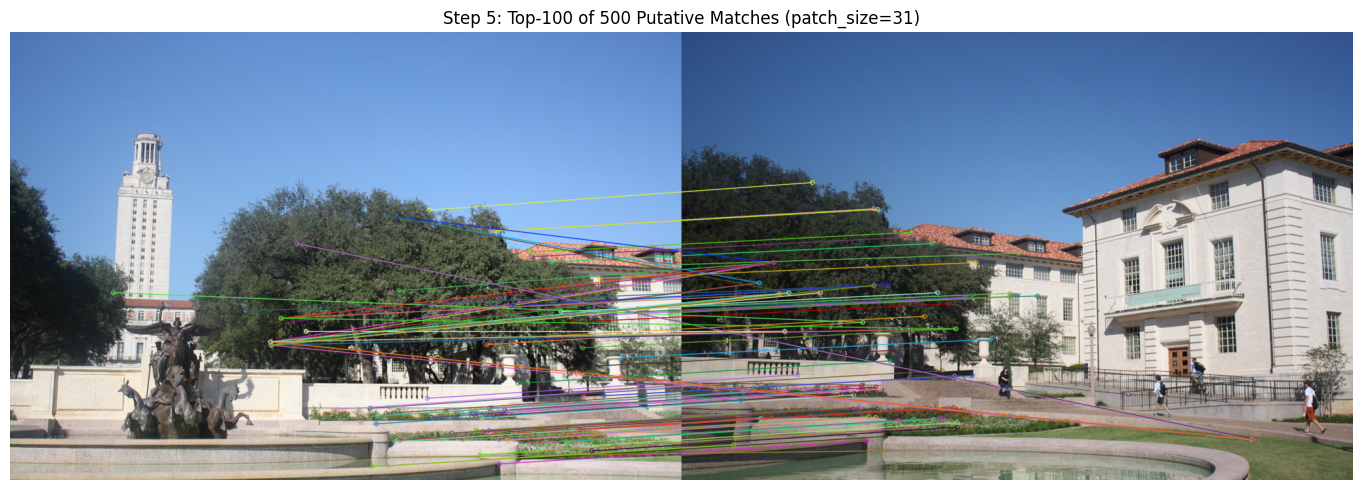

In [36]:

# Visualize putative matches on side-by-side images
# Convert float64 to uint8 for OpenCV drawing functions
img_left_u8 = (img_left_rgb * 255).astype(np.uint8)
img_right_u8 = (img_right_rgb * 255).astype(np.uint8)

# Build cv2.KeyPoint lists (x=col, y=row) and DMatch list for visualization
kp1_cv = [cv2.KeyPoint(float(x), float(y), 1.0) for y, x in pts_left]
kp2_cv = [cv2.KeyPoint(float(x), float(y), 1.0) for y, x in pts_right]
matches_cv = [cv2.DMatch(i, i, float(dist_matrix[match_left_idx[i], 
                                                 match_right_idx[i]]))
              for i in range(TOP_N)]

# drawMatches places img_right to the right of img_left
putative_img = cv2.drawMatches(
    img_left_u8, 
    kp1_cv, 
    img_right_u8, 
    kp2_cv,
    matches_cv[:TOP_N//5],  # display first 100 for clarity
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(18, 5))
plt.imshow(putative_img)
plt.title(f'Step 5: Top-100 of {TOP_N} Putative Matches (patch_size={PATCH_SIZE})')
plt.axis('off'); plt.tight_layout(); plt.show()

# Step 6: RANSAC — Affine Transformation and Homography

RANSAC (Random Sample Consensus) robustly estimates a geometric transformation
in the presence of outlier matches (incorrect putative correspondences).

**Algorithm for each iteration:**
1. Randomly sample the minimum number of correspondences needed (3 for affine, 4 for homography)
2. Fit the transformation to this minimal sample
3. Count "inliers": putative matches whose reprojection error is below a threshold
4. Keep the hypothesis with the most inliers

**After RANSAC:** Refit the final transformation using ALL identified inliers
(not just the minimal sample) for maximum accuracy.

- **Affine** (6 DOF): preserves parallelism; models rotation, scale, shear, translation.
- **Homography** (8 DOF): models full projective transformation; needed when camera rotates between the two images.
- **Residual** = average squared distance between predicted and actual match coordinates for inlier pairs.

2026-03-01 23:08:16,493 - ── Affine RANSAC Results ──
2026-03-01 23:08:16,494 -   Inlier count:                  101 / 500
2026-03-01 23:08:16,494 -   Average residual (squared px): 6.7653
2026-03-01 23:08:16,494 -   Affine matrix:
[[ 9.61610875e-01 -6.34769987e-02 -3.92043332e+02]
 [ 3.01706762e-02  9.65906366e-01 -3.85650474e+01]]
2026-03-01 23:08:16,521 - ── Homography RANSAC Results ──
2026-03-01 23:08:16,522 -   Inlier count:                  135 / 500
2026-03-01 23:08:16,522 -   Average residual (squared px): 0.7650
2026-03-01 23:08:16,522 -   Homography matrix:
[[ 1.28966738e+00 -7.75758085e-02 -5.67926115e+02]
 [ 1.66717047e-01  1.20677238e+00 -1.63138731e+02]
 [ 2.75158296e-04  1.17512664e-05  1.00000000e+00]]


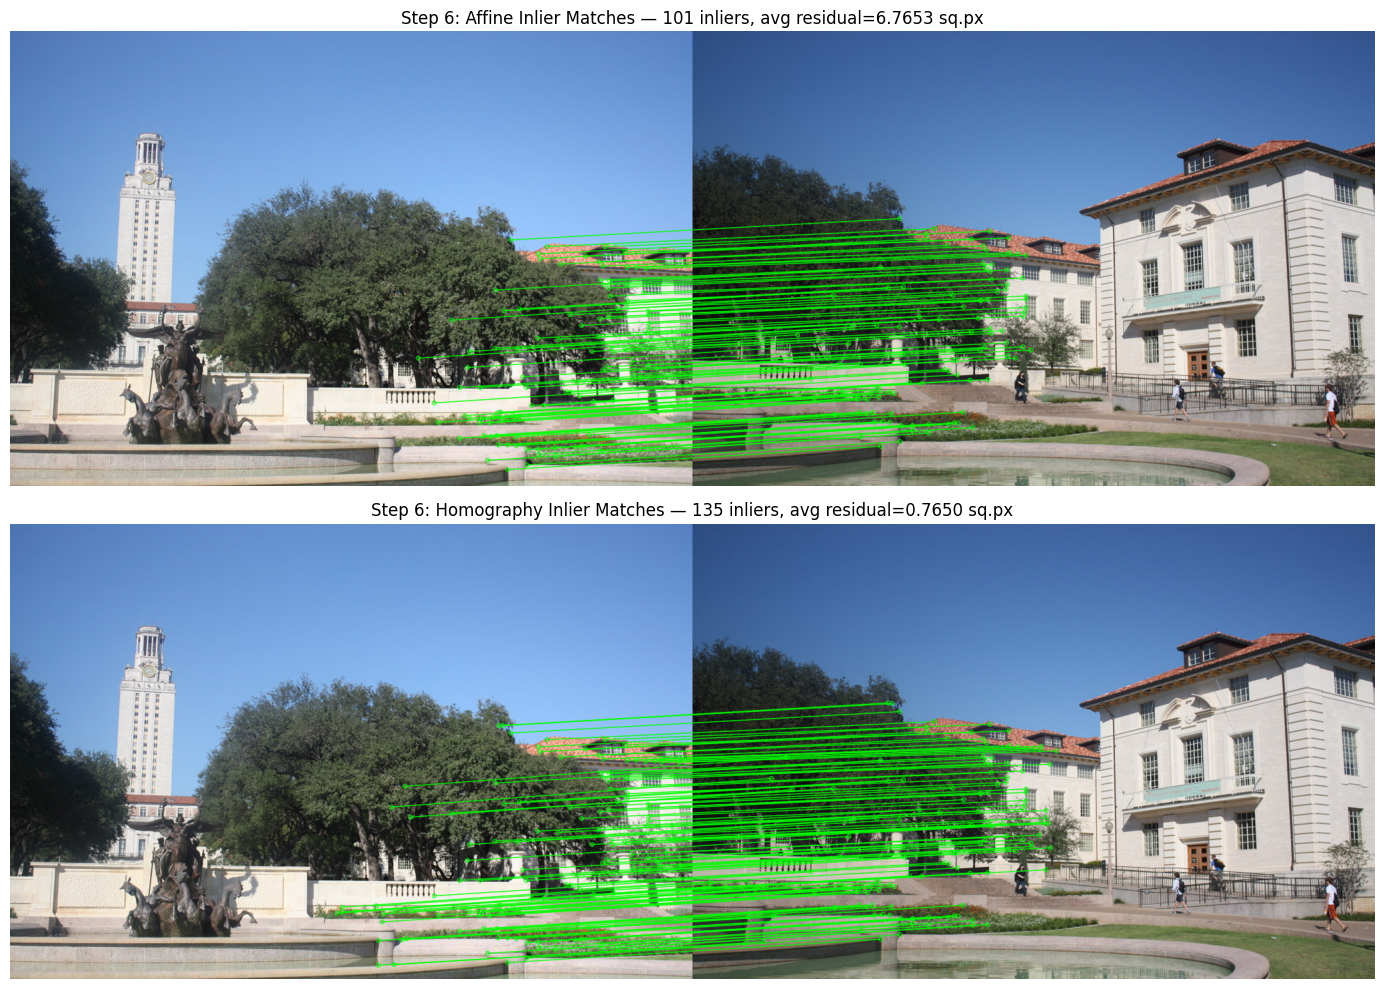

In [45]:
# -- Step 6: RANSAC for Affine Transformation and Homography -------------------

# Convert point arrays from (row, col) to (x=col, y=row) for OpenCV convention.
# OpenCV geometric functions expect points in (x, y) = (col, row) order.
pts_left_xy  = pts_left[:,  [1, 0]].astype(np.float32)   # (N, 2): (col, row)
pts_right_xy = pts_right[:, [1, 0]].astype(np.float32)   # (N, 2): (col, row)


def compute_residuals_affine(M_2x3: np.ndarray, 
                             src_pts: np.ndarray, 
                             dst_pts: np.ndarray) -> np.ndarray:
    """
    Compute per-point squared reprojection error for an affine transform M (2x3).
    src_pts, dst_pts: (N, 2) float32

    Args:
        M_2x3: affine transformation matrix of shape (2, 3)
        src_pts: source points (N, 2) in (col, row) order
        dst_pts: destination points (N, 2) in (col, row) order

    Returns: 
        (N,) float64 squared distances
    """
    src_h = np.hstack([src_pts, 
                       np.ones((len(src_pts), 1), dtype=np.float64)])  # (N, 3)
    pred = (M_2x3.astype(np.float64) @ src_h.T).T    # (N, 2)
    diff = pred - dst_pts.astype(np.float64)
    return np.sum(diff**2, axis=1)

def compute_residuals_homography(H_3x3: np.ndarray, 
                                src_pts: np.ndarray, 
                                dst_pts: np.ndarray) -> np.ndarray:
    """
    Compute per-point squared reprojection error for homography H (3x3).
    Uses perspective division: p' = H*p / (H[2]*p)
    src_pts, dst_pts: (N, 2) float32

    Args:
        H_3x3: homography matrix of shape (3, 3)
        src_pts: source points (N, 2) in (col, row) order
        dst_pts: destination points (N, 2) in (col, row) order

    Returns: 
        (N,) float64 squared distances
    """
    src_reshaped = src_pts.reshape(-1, 1, 2).astype(np.float32)
    pred = cv2.perspectiveTransform(src_reshaped, 
                                    H_3x3.astype(np.float64))  # (N, 1, 2)
    pred = pred.reshape(-1, 2).astype(np.float64)
    diff = pred - dst_pts.astype(np.float64)
    return np.sum(diff**2, axis=1)

# -- 6a: RANSAC for Affine -----------------------------------------------------
# Affine transform has 6 DOF; minimum sample size is 3 correspondences.
# cv2.getAffineTransform(src, dst) requires exactly 3 points, returns a 2x3 matrix.

N_pts = len(pts_left_xy)
best_affine_inliers = np.array([], dtype=int)
best_M_affine = None

np.random.seed(42)  # reproducibility

for iteration in range(RANSAC_ITERATIONS):
    # Sample 3 distinct correspondences at random
    sample_idx = np.random.choice(N_pts, 3, replace=False)
    src_sample = pts_left_xy[sample_idx]    # (3, 2)
    dst_sample = pts_right_xy[sample_idx]   # (3, 2)
    
    # Fit affine transform from the 3-point sample
    M = cv2.getAffineTransform(src_sample, dst_sample)   # (2, 3) float64
    
    # Evaluate on all putative matches
    resid_sq = compute_residuals_affine(M, pts_left_xy, pts_right_xy)
    
    # Inliers: squared distance < threshold^2
    inlier_idx = np.where(resid_sq < RANSAC_THRESHOLD ** 2)[0]
    
    if len(inlier_idx) > len(best_affine_inliers):
        best_affine_inliers = inlier_idx
        best_M_affine = M

# Refit affine using ALL inliers (least-squares, not just 3 points)
M_affine_final, _ = cv2.estimateAffine2D(
    pts_left_xy[best_affine_inliers].reshape(-1, 1, 2),
    pts_right_xy[best_affine_inliers].reshape(-1, 1, 2),
    # method=0    # 0 = least squares (no additional RANSAC)
)

# Compute and report statistics for affine
resid_sq_affine = compute_residuals_affine(M_affine_final,
                                           pts_left_xy[best_affine_inliers],
                                           pts_right_xy[best_affine_inliers])
avg_resid_affine = resid_sq_affine.mean()

logging.info("── Affine RANSAC Results ──")
logging.info("  Inlier count:                  %d / %d", len(best_affine_inliers), N_pts)
logging.info("  Average residual (squared px): %.4f", avg_resid_affine)
logging.info("  Affine matrix:\n%s", M_affine_final)

# -- 6b: RANSAC for Homography -------------------------------------------------
# Homography has 8 DOF; minimum sample size is 4 correspondences.
# cv2.getPerspectiveTransform(src, dst) requires exactly 4 points, returns 3x3 matrix.

best_hom_inliers = np.array([], dtype=int)
best_H_hom = None

np.random.seed(42)  # reproducibility

for iteration in range(RANSAC_ITERATIONS):
    sample_idx = np.random.choice(N_pts, 4, replace=False)
    src_sample = pts_left_xy[sample_idx]    # (4, 2)
    dst_sample = pts_right_xy[sample_idx]   # (4, 2)
    
    # Fit homography from the 4-point sample
    H = cv2.getPerspectiveTransform(src_sample, dst_sample)   # (3, 3) float64
    
    # Evaluate on all putative matches
    resid_sq = compute_residuals_homography(H, pts_left_xy, pts_right_xy)
    
    inlier_idx = np.where(resid_sq < RANSAC_THRESHOLD ** 2)[0]
    
    if len(inlier_idx) > len(best_hom_inliers):
        best_hom_inliers = inlier_idx
        best_H_hom = H

# Refit homography using all inliers with least-squares (method=0)
H_final, _ = cv2.findHomography(
    pts_left_xy[best_hom_inliers].reshape(-1, 1, 2),
    pts_right_xy[best_hom_inliers].reshape(-1, 1, 2),
    method=0   # least squares over all inliers
)

# Compute and report statistics for homography
resid_sq_hom = compute_residuals_homography(H_final,
                                             pts_left_xy[best_hom_inliers],
                                             pts_right_xy[best_hom_inliers])
avg_resid_hom = resid_sq_hom.mean()

logging.info("── Homography RANSAC Results ──")
logging.info("  Inlier count:                  %d / %d", len(best_hom_inliers), N_pts)
logging.info("  Average residual (squared px): %.4f", avg_resid_hom)
logging.info("  Homography matrix:\n%s", H_final)

# -- Display inlier matches for BOTH transforms --------------------------------
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

for ax, inliers, title, avg_r in [
    (axes[0], best_affine_inliers, 'Affine', avg_resid_affine),
    (axes[1], best_hom_inliers,    'Homography', avg_resid_hom),
]:
    kp1_in = [cv2.KeyPoint(float(c), float(r), 1.0) for r, c in pts_left[inliers]]
    kp2_in = [cv2.KeyPoint(float(c), float(r), 1.0) for r, c in pts_right[inliers]]
    m_in   = [cv2.DMatch(i, i, 0.0) for i in range(len(inliers))]
    match_vis = cv2.drawMatches(img_left_u8, kp1_in, img_right_u8, kp2_in,
                                 m_in, None,
                                 matchColor=(0, 255, 0),
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    ax.imshow(match_vis)
    ax.set_title(f'Step 6: {title} Inlier Matches — {len(inliers)} inliers, '
                 f'avg residual={avg_r:.4f} sq.px')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Step 7: Warp One Image onto the Other

We use the homography H (which maps left image coordinates to right image coordinates)
to warp the left image into the right image's frame. This requires computing the
canvas size dynamically by transforming the four corners of the left image through H.

The right image is held fixed; the left image is projected into it.

2026-03-01 23:09:10,269 - Canvas size: 1641 x 848  (offset: x=616, y=164)
2026-03-01 23:09:10,276 - Warped left image shape: (848, 1641, 3)


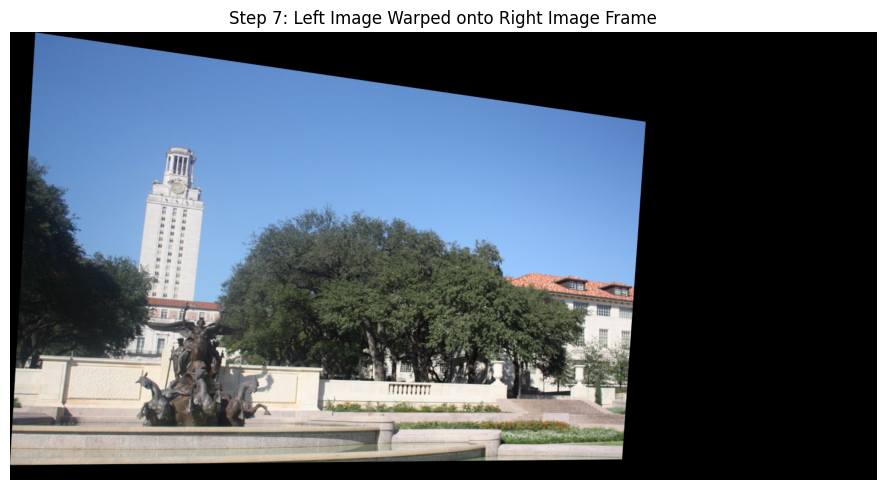

In [ ]:
# -- Step 7: Warp Left Image onto Right Image Frame ----------------------------
# H_final maps (x, y) points from the LEFT image to (x', y') in the RIGHT image frame.
# To create a panorama, we need a canvas large enough to show BOTH images.
#
# Strategy:
#   1. Project the four corners of the left image through H to find their locations
#      in the right image frame.
#   2. Compute x_offset and y_offset to shift everything so no coordinates are negative.
#   3. Build a translation matrix T that applies this offset.
#   4. The composite homography T @ H_final warps the left image into the shifted frame.
#   5. Place the right image at the (x_offset, y_offset) position on the canvas.

# Four corners of the left image in (x, y) order: TL, TR, BR, BL
corners_left = np.float32([[0, 0], [W_img, 0], [W_img, H_img], [0, H_img]])
corners_left = corners_left.reshape(-1, 1, 2)   # (4, 1, 2) for perspectiveTransform

# Project left image corners into the right image frame using H_final
corners_warped = cv2.perspectiveTransform(corners_left, H_final.astype(np.float64))
corners_warped = corners_warped.reshape(-1, 2)   # (4, 2)

# All canvas corners including the right image corners (which sit at the origin)
corners_right = np.float32([[0, 0], [W_img, 0], [W_img, H_img], [0, H_img]])
all_corners = np.vstack([corners_warped, corners_right])   # (8, 2)

# Compute canvas extent
x_min, y_min = all_corners.min(axis=0)
x_max, y_max = all_corners.max(axis=0)

# Translation offsets ensure all coordinates are non-negative on the canvas
x_offset = int(np.ceil(max(0.0, -x_min)))
y_offset = int(np.ceil(max(0.0, -y_min)))

# Canvas dimensions
canvas_w = int(np.ceil(x_max + x_offset)) + 1
canvas_h = int(np.ceil(y_max + y_offset)) + 1

logging.info("Canvas size: %d x %d  (offset: x=%d, y=%d)", canvas_w, canvas_h, x_offset, y_offset)

# Build the translation matrix T (3x3) that shifts everything by (x_offset, y_offset)
T = np.array([[1.0, 0.0, x_offset],
              [0.0, 1.0, y_offset],
              [0.0, 0.0, 1.0]], dtype=np.float64)

# Composite homography: warp left image into the translated right frame
H_composite = T @ H_final   # (3, 3)

# Warp the left image (as float64 RGB) onto the canvas using the composite homography.
# INTER_LINEAR provides bilinear interpolation for smooth sub-pixel sampling.
# BORDER_CONSTANT fills regions outside the source image with 0 (black).
img_left_warped = cv2.warpPerspective(
    img_left_rgb,
    H_composite,
    (canvas_w, canvas_h),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=0
)   # shape: (canvas_h, canvas_w, 3) float64

logging.info("Warped left image shape: %s", img_left_warped.shape)

# Display the warped left image alone
plt.figure(figsize=(16, 5))
plt.imshow(img_left_warped)
plt.title('Step 7: Left Image Warped onto Right Image Frame')
plt.axis('off'); plt.tight_layout(); plt.show()

# Step 8: Create Panorama, Composite, and Save

Place the right image on the canvas at position `(x_offset, y_offset)`.
In overlapping regions (where both images have non-zero pixel values), average
the pixel values from each image. In non-overlapping regions, use whichever
image has content. Save the result as `stitched_output.jpg`.

In [ ]:
# -- Step 8: Create Panoramic Canvas, Composite, and Save ----------------------

# Place the right image on the canvas at the computed offset position.
# All processing is done in float64 [0, 1] range for numerical accuracy.
canvas_right = np.zeros((canvas_h, canvas_w, 3), dtype=np.float64)
canvas_right[y_offset : y_offset + H_img,
             x_offset : x_offset + W_img] = img_right_rgb   # float64 [0,1]

# Both canvas layers are now aligned:
#   img_left_warped  : left image warped into composite frame, float64 (canvas_h, canvas_w, 3)
#   canvas_right     : right image placed at offset, float64 (canvas_h, canvas_w, 3)

# Build binary masks for each image: 1 where the image has valid (non-black) content.
# Using sum-over-channels > 0 as the indicator (works because background is exactly 0).
mask_left  = (img_left_warped.sum(axis=2) > 0).astype(np.float64)   # (canvas_h, canvas_w)
mask_right = (canvas_right.sum(axis=2)    > 0).astype(np.float64)   # (canvas_h, canvas_w)

# Classify each canvas pixel into three regions:
#   overlap    : both images contribute -> average them
#   only_left  : only left image has content -> use left
#   only_right : only right image has content -> use right
overlap    = mask_left  * mask_right                      # 1 where both present
only_left  = mask_left  * (1.0 - mask_right)             # 1 where only left
only_right = mask_right * (1.0 - mask_left)              # 1 where only right

# Expand masks to (H, W, 1) for broadcasting with 3-channel images
def expand(mask):
    return mask[:, :, np.newaxis]

# Composite: weighted sum of contributions per region
panorama = (
    expand(only_left)  * img_left_warped +                          # left-only region
    expand(only_right) * canvas_right    +                          # right-only region
    expand(overlap)    * (img_left_warped + canvas_right) / 2.0     # overlap: average
)   # shape: (canvas_h, canvas_w, 3), float64 [0, 1]

logging.info("Panorama shape: %s  min=%.4f  max=%.4f",
             panorama.shape, panorama.min(), panorama.max())

# Convert back to uint8 BGR for cv2.imwrite
panorama_bgr = cv2.cvtColor(
    np.clip(panorama * 255, 0, 255).astype(np.uint8),
    cv2.COLOR_RGB2BGR
)

# Save to stitched_output.jpg
OUTPUT_PATH = 'stitched_output.jpg'
success = cv2.imwrite(OUTPUT_PATH, panorama_bgr)
logging.info("Saved stitched output to '%s': %s", 
             OUTPUT_PATH, 'OK' if success else 'FAILED')

# Display the final panorama
plt.figure(figsize=(18, 6))
plt.imshow(panorama)
plt.title(f'Step 8: Final Panorama — saved as {OUTPUT_PATH}\n'
          f'Canvas: {canvas_w}x{canvas_h} px  |  patch_size={PATCH_SIZE}  |  '
          f'RANSAC inliers (Affine): {len(best_affine_inliers)}  (Homography): {len(best_hom_inliers)}')
plt.axis('off'); plt.tight_layout(); plt.show()

## Summary Table

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Harris blockSize | 3 | Standard neighborhood for covariance matrix |
| Harris ksize | 3 | Sobel aperture; balances noise and precision |
| Harris k | 0.04 | Original Harris & Stephens constant |
| Harris threshold | 0.01 * max | Retains top 1% of responses |
| NMS kernel | 9x9 | Suppresses clusters; yields ~1000 keypoints |
| Patch size | 31x31 (961-dim) | Good balance of distinctiveness and tolerance |
| Descriptor normalization | Zero-mean | Invariance to brightness offsets |
| Putative matches | Top-500 | Controlled, threshold-free selection |
| RANSAC iterations | 1000 | >99.9% success at 50% outlier rate |
| RANSAC threshold | 5.0 px | Standard for feature matching |
| Warp direction | Left → Right frame | Right image held fixed, H used directly |
| Overlap compositing | Pixel averaging | Simple, artifact-free blend |